# NVIDIA PhysicsNemo Sym Introduction
- DL framework that allows ML to be applied to physics-based problems (PINNs)
- This is introductory example for creating a PINN to solve 2D flow for lid driven cavity: https://docs.nvidia.com/deeplearning/physicsnemo/physicsnemo-sym/user_guide/basics/lid_driven_cavity_flow.html
- Square cavity 0.1x0.1m, with origin at center. Walls are stationary except top wall which moves in x-direction at 1m/s
- Reynolds number is 10 indicating laminar flow

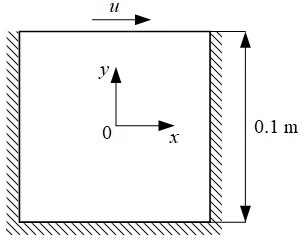

In [ ]:
!pip install nvidia-physicsnemo
!pip install Cython
!pip install nvidia-physicsnemo-sym --no-build-isolation
!pip install warp-lang

In [ ]:
import os
import warnings

from sympy import Symbol, Eq, Abs

import physicsnemo.sym
from physicsnemo.sym.hydra import to_absolute_path, instantiate_arch, PhysicsNeMoConfig
from physicsnemo.sym.solver import Solver
from physicsnemo.sym.domain import Domain
from physicsnemo.sym.geometry.primitives_2d import Rectangle
from physicsnemo.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)
from physicsnemo.sym.domain.validator import PointwiseValidator
from physicsnemo.sym.domain.inferencer import PointwiseInferencer
from physicsnemo.sym.key import Key
from physicsnemo.sym.eq.pdes.navier_stokes import NavierStokes
from physicsnemo.sym.utils.io import (
    csv_to_dict,
    ValidatorPlotter,
    InferencerPlotter
)

## Creating PDE Node
- The PDE is 2D steady-state incompressible Navier-Stokes equation which are system of PDEs that describe flow velocity and pressure at every point in the 2D domain
- x and y are the independent variables
- 3 dependent variables to solve for
  - u is the flow velocity in x direction
  - v is flow velocity in y direction
  - p is pressure at point (x,y)
- There are two parameters (constant in this case)
  - v is the kinematic velocity
  - $\rho$ is the density of fluid
- First equation is the **continuity** equation which expresses that flow is incompressible (flow is divergence free)
- Second and third are the **momentum** equations

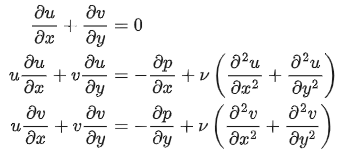

- A **Node** in PhysicsNemo are components to be executed in forward pass during training. A Node may be a PDE, a neural network, a loss, etc.
- In code below, we create a PDE node called "ns" by calling the NavierStokes function and passing in the kinematic viscosity and density
- Time set to false because this is steady-state not transient

## Creating Neural Network Node
- NN to approximate the solution of the PDE
- Made using the instantiate_arch function, which takes a list of input and output **Keys**, which are like the independent and dependent variables. These are like the symbolic representation, and the Key objects should have the same name as Symbol objects used later
- There are several different NN architectures in PhysicsNemo. Setting cfg to cfg.arch.fully_connected is the default architecture
  - Multi-layer perceptron NN with 6 layers
  - 512 neurons each layer
  - swish aka SiLU activation function
  - These parameters are the defaults, but they can be configured as well

## Hydra Configuration Files
- Hydra configuration files are text files in YAML format which is used to customize the PhysicsNeMo Sym features
- Ex) define the optimizer, loss, architecture, learning rate, steps, etc


defaults:
  - physicsnemo_default
  - arch:
      - fully_connected
  - scheduler: tf_exponential_lr
  - optimizer: adam
  - loss: sum
  - _self_
scheduler:
  decay_rate: 0.95
  decay_steps: 4000

training:
  rec_validation_freq: 1000
  rec_inference_freq: 2000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  max_steps: 10000

batch_size:
  TopWall: 1000
  NoSlip: 1000
  Interior: 4000

graph:
  func_arch: true

## Creating Geometry
- Define physical shape of domain and boundaries
- Several ways to define geometry, there are modules to create primitive shapes, or can import a mesh
- CSG module allows creation of primitive 2D and 3D shapes (rectangle, circle, etc)
- Need to define the symbolic variables for geometry. These should be named same as the Keys for the NN
  - Uses SymPy for symbolic variables
- Rectangles are defined using the coordinates for two opposite corner points

## Adding Constraints
- Constraints are the training objectives (Boundary, PDE)
### Setting Up Domain
- A **Domain** object contains the PDE and boundary conditions, which are the constraints of the problem
  - PDE constraints outputs on the interior of the domain, while boundary conditions constraints output on the exterior of domain
- Other utilities can be added to a Domain such as monitors, validators, or inference points
- Adding constraints to the Domain are like adding constraints to the NN optimization problem
  - Satisfy boundary conditions exactly
  - Have interior (PDE) residual go to zero
- A **loss function** is constructed from the constraints, using a L2 loss (MSE) by default
- A constraint is added to a Domain object using the .add_constraint() method

### Boundary Constraints
- Created using a PointwiseBoundaryConstraint object. This "samples the boundary", which creates a set of points that live on that part of the geometry
- The nodes to evaluate on the boundary are the NavierStokes node and the NN node, they are specified to be evaluated at the sample points
  - "Evaluate" synonymous with "unrolling the nodes", meaning to construct the computational graph on the list of nodes
  - Output of a Constraint is a loss
- geometry=rec samples all sides of the rectangle. To sample a specific side, use the criteria argument
  - Criteria set to a **symbolic function** using the **sympy** library Eq() function, where the first argument is the LHS and second is the RHS (i.e sample all points of rectangle where y=height/2.0) to get top wall
    - Or it can be done just using regular expression ex. y=height/2
- The **outvar** argument specifies the desired values for the BC as a dictionary
  - In code, u output is 1.0 on top wall and v is 0.0
- The batch_size agument specifies number of points to sample on the boundary
- At the corners of the walls there is a sharp discontinuity in u velocity. To avoid this, have a weight that applies to the u of the top wall that varies across the top wall and goes to 0 at the corner. This is done using the lambda_weighting parameter

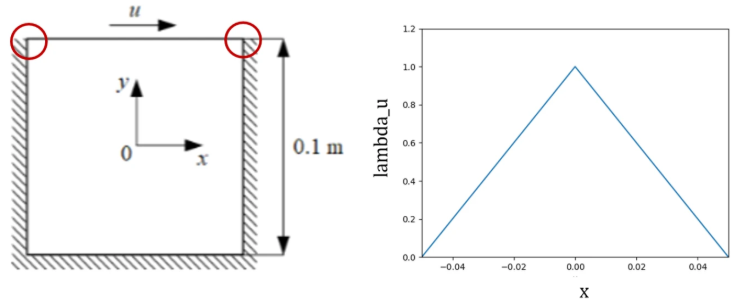

### PDE Constraints
- Use PointwiseInteriorConstraint class to sample points on the interior of the geometry. Same with the BC, specify the nodes to evaluate on those points, and assign the true values desired (PDE)
- **outvar** argument specifies equations to solve as dictionary. For current problem there are 3 equations need to be satisfied, therefore there are 3 keys in the dictionary, which must evaluate to zero which is the desired residual
  - See documentation for the naming of equations as defined in the NavierStokes node object
  - If a nonzero value is used it behaves as a forcing or source term
- The **lambda_weighting** parameter determines the weights for different losses
  - **Signed distance field (SDF)** is method to weight each equation loss at each point. Points further from boundary are assigned larger weight leading to faster convergence
  - If nothing is provided for lambda_weighting, loss for each equation/boundary variable at each point is weighted equally


### Validation
- Validation nodes can be added to the domain using PointwiseValidator
- Compare the outputs of the NN to external data, in current problem compare to results from OpenFOAM
- Data must be converted into dictionary of NumPy variables for input and output

## Solve
- Create Solver() object and pass in the config file and the domain

In [ ]:
# define the path to the Hydra config file and its name
@physicsnemo.sym.main(config_path="conf", config_name="config")

# define the list of nodes for PDE and architecture
def run(cfg: PhysicsNeMoConfig) -> None:
  ns = NavierStokes(nu=0.01, rho=1.0, dim=2, time=False)
  flow_net = instantiate_arch(
      input_keys=[Key("x"),Key("y")],
      output_keys=[Key("u"),Key("v"),Key("p")],
      cfg=cfg.arch.fully_connected
  )

  # make list of nodes
  nodes = ns.make_nodes() + [flow_net.make_node(name="flow_network")]

  # make geometry
  height = 0.1
  width = 0.1
  x, y = Symbol("x"), Symbol("y")
  rec = Rectangle((-width/2.0, -height/2.0), (width/2.0, height/2.0))

  ldc_domain = Domain()

  # define the top wall BC
  top_wall = PointwiseBoundaryConstraint(
     nodes=nodes,
     geometry=rec,
     outvar={"u": 1.0, "v": 0},
     batch_size=cfg.batch_size.TopWall,
     lambda_weighting={"u": 1.0-20*Abs(x), "v": 1.0},
     criteria=Eq(y, height/2.0)
  )
  ldc_domain.add_constraint(top_wall, "top_wall")

  # define the rest of the BCs as no slip
  no_slip = PointwiseBoundaryConstraint(
      nodes=nodes,
      geometry=rec,
      outvar={"u": 0.0, "v": 0.0},
      batch_size=cfg.batch_size.NoSlip,
      critera=y<height/2.0
  )
  ldc_domain.add_constraint(no_slip, "no_slip")

  # define the interior constraint (PDE)
  interior = PointwiseInteriorConstraint(
      nodes=nodes,
      geometry=rec,
      outvar={"continuity": 0, "momentum_x": 0, "momentum_y": 0},
      batch_size=cfg.batch_size.Interior,
      lambda_weighting={
          "continuity": Symbol("sdf"),
          "momentum_x": Symbol("sdf"),
          "momentum_y": Symbol("sdf"),
      }
  )
  ldc_domain.add_constraint(interior, "interior")

  # add validator. since I don't have the csv the validator won't be added
  file_path = "folder/validationdata.csv"
  if os.path.exists(to_absolute_path(file_path)):
    # map keys from CSV to keys in dict (not a mandatory argument)
    mapping = {"Points:0": "x", "Points:1": "y", "U:0": "u", "U:1": "v", "p": "p"}
    openfoam_var = csv_to_dict(to_absolute_path(file_path), mapping)
    openfoam_var["x"] += -width/2 # center data
    openfoam_var["y"] += -height/2 # center data
    openfoam_invar_numpy = {
        key: value for key, value in openfoam_var.items() if key in ["x", "y"]
    }
    openfoam_outvar_numpy = {
        key: value for key, value in openfoam_var.items() if key in ["u", "v"]
    }
    openfoam_validator = PointwiseValidator(
        nodes=nodes,
        invar=openfoam_invar_numpy,
        true_outvar=openfoam_outvar_numpy,
        batch_size=1024,
        plotter=ValidatorPlotter()
    )
    ldc_domain.add_validator(openfoam_validator)
  else:
    warnings.warn(
        f'Directory {file_path} does not exist. Will skip adding validators.'
    )

  # make solver
  slv = Solver(cfg, ldc_domain)
  slv.solve()

if __name__ == "__main__":
  run()

/usr/local/lib/python3.11/dist-packages/physicsnemo/sym/hydra/config.py:152: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(
usage: colab_kernel_launcher.py [--help] [--hydra-help] [--version]
                                [--cfg {job,hydra,all}] [--resolve]
                                [--package PACKAGE] [--run] [--multirun]
                                [--shell-completion]
                                [--config-path CONFIG_PATH]
                                [--config-name CONFIG_NAME]
                                [--config-dir CONFIG_DIR]
                                [--experimental-rerun EXPERIMENTAL_RERUN]
                                [--info [{all,config,defaults,defaults-tree,plugins,searchpath}]]
                                [overrides ...]
colab_kernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
